Here the necessary libraries are imported for the model.

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

The KDDTrain and KDDTest samples are downloaded.

In [3]:
!wget https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt

--2025-06-10 16:53:44--  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19109424 (18M) [text/plain]
Saving to: ‘KDDTrain+.txt’

KDDTrain+.txt       100%[===================>]  18.22M  37.4MB/s    in 0.5s    

2025-06-10 16:53:46 (37.4 MB/s) - ‘KDDTrain+.txt’ saved [19109424/19109424]



In [4]:
!wget https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt

--2025-06-10 16:53:48--  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3441513 (3.3M) [text/plain]
Saving to: ‘KDDTest+.txt’

KDDTest+.txt        100%[===================>]   3.28M  13.1MB/s    in 0.3s    

2025-06-10 16:53:49 (13.1 MB/s) - ‘KDDTest+.txt’ saved [3441513/3441513]



Column names for the features, label and difficulty from the KDD Dataset are enumerated, and the data loaded from the CSV

In [11]:
cols = [f'feature_{i}' for i in range(41)] + ['label', 'difficulty']
df = pd.read_csv("KDDTrain+.txt", header=None, names=cols)

The data is encoded, labels specified (there are numberous attack labels in the KDD Dataset, they are all classified under one label), and the features normalized. The data is then split into train and evaluation splits.

In [12]:
# Encode categorical
for col in ['feature_1', 'feature_2', 'feature_3']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Binary label: 0 = normal, 1 = attack
df['label'] = df['label'].apply(lambda x: 0 if x == 'normal' else 1)

# Normalize features
X = df.iloc[:, :-2].values
y = df['label'].values
X = StandardScaler().fit_transform(X)

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

This is where the Dataset is preprocessed before feeding to the model, by creating tensors, and after that the IDS model architecture is defined, with 3 Linear layers and 2 Rectified Linear Unit (ReLU) layers in-between each.

In [13]:
class IntrusionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(IntrusionDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(IntrusionDataset(X_val, y_val), batch_size=64)

In [14]:
class SimpleIDSModel(nn.Module):
    def __init__(self, input_size):
        super(SimpleIDSModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # No sigmoid
        )
    def forward(self, x):
        return self.net(x)

Model is trained with the various hyperparameters such as the criterion (loss function) and the optimizer. Epochs are the number of times the model goes through the training loop. Decreasing loss for each epoch means the model is learning, and more epochs may lead to better performance at the cost of training resources.

In [15]:
model = SimpleIDSModel(X.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    for i, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Forward pass (logits only)
        logits = model(X_batch).view(-1)
        loss = criterion(logits, y_batch)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # optional
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Output monitoring for first batch in each epoch
        if i == 0:
            with torch.no_grad():
                probs = torch.sigmoid(logits)
                print(f"\nEpoch {epoch+1}")
                print("  Logits:", logits[:5].numpy())
                print("  Probabilities:", probs[:5].numpy())
                print("  Targets:", y_batch[:5].numpy())
    
    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")


Epoch 1
  Logits: [-0.09146228 -0.17194918 -0.16620973 -0.1687215  -0.10673405]
  Probabilities: [0.47715032 0.4571183  0.45854297 0.4579194  0.47334176]
  Targets: [1. 0. 0. 0. 1.]
Epoch 1 Loss: 351.0091

Epoch 2
  Logits: [-1.992386   6.0422745 -4.584759  -3.7289672 -4.790593 ]
  Probabilities: [0.12000466 0.99762946 0.01010309 0.02345431 0.00823908]
  Targets: [1. 1. 0. 0. 0.]
Epoch 2 Loss: 127.9977

Epoch 3
  Logits: [ 6.911761   -0.96739316  4.5789156   4.548613    3.0381422 ]
  Probabilities: [0.999005   0.2754004  0.98983824 0.98952895 0.95426786]
  Targets: [1. 0. 1. 1. 1.]
Epoch 3 Loss: 95.3207

Epoch 4
  Logits: [-5.6969457 -4.7877383 -5.778388  -5.5837092  7.5258374]
  Probabilities: [0.00334497 0.00826244 0.00308416 0.00374452 0.99946135]
  Targets: [0. 0. 0. 0. 1.]
Epoch 4 Loss: 72.6620

Epoch 5
  Logits: [-6.0059843 13.65903   -5.0342255 -6.4327526 10.449551 ]
  Probabilities: [0.00245791 0.9999988  0.00646912 0.00160544 0.99997103]
  Targets: [0. 1. 0. 0. 1.]
Epoch 5 Lo

Here the model is evaluated, and scores are calculated. The model shows a 99$ accuracy for the training data. 

In [16]:
model.eval()
y_preds, y_trues = [], []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        logits = model(X_batch).view(-1)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int()
        
        y_preds.extend(preds.numpy())
        y_trues.extend(y_batch.int().numpy())

from sklearn.metrics import classification_report
print(classification_report(y_trues, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     13422
           1       0.99      0.99      0.99     11773

    accuracy                           0.99     25195
   macro avg       0.99      0.99      0.99     25195
weighted avg       0.99      0.99      0.99     25195



Confusion matrix showing a pretty low number of false positives and negatives.

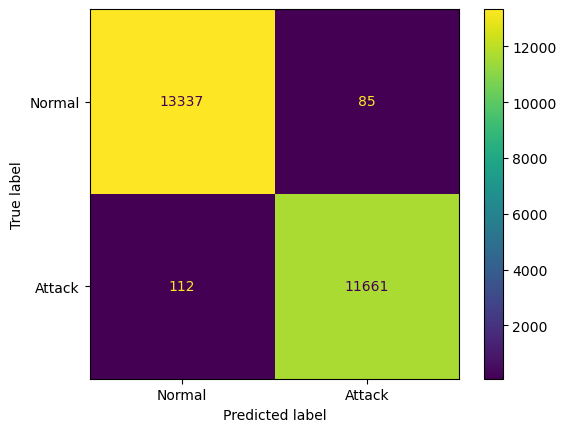

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_trues, y_preds)
ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Attack']).plot()

The model is saved for deployment.

In [12]:
torch.save(model.state_dict(), "intrusion_detection_model.pth")

The model appears to run great on known data. However, the true evaluation for the model comes from its performance on unseen data, for which we use the KDDTest part of the dataset.

              precision    recall  f1-score   support

           0       0.68      0.97      0.80      9711
           1       0.97      0.65      0.78     12833

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.84      0.79      0.79     22544



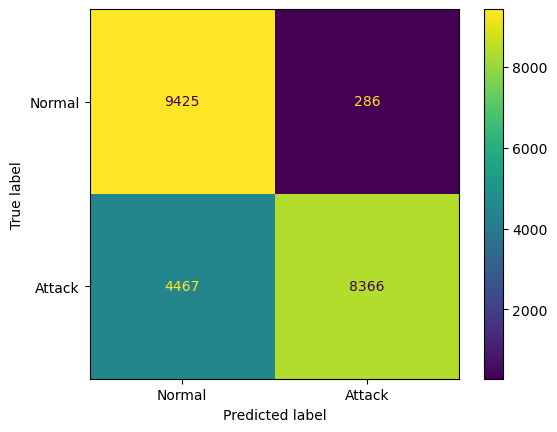

In [19]:
cols = [f'feature_{i}' for i in range(41)] + ['label', 'difficulty']
df_test = pd.read_csv("KDDTest+.txt", header=None, names=cols)

# Encode categorical
for col in ['feature_1', 'feature_2', 'feature_3']:
    df_test[col] = LabelEncoder().fit_transform(df_test[col])

# Binary classification: normal = 0, attack = 1
df_test['label'] = df_test['label'].apply(lambda x: 0 if x == 'normal' else 1)

# Separate features and labels
X_test_raw = df_test.iloc[:, :-2].values
y_test = df_test['label'].values

# Normalize using same scaler as training (refit StandardScaler if not saved)
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test_raw)

# Convert to PyTorch dataset
class IntrusionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

test_dataset = IntrusionDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64)

# -------------------------------
# 3. Load trained model
# -------------------------------
model = SimpleIDSModel(X_test.shape[1])
model.load_state_dict(torch.load("intrusion_detection_model.pth"))
model.eval()

# -------------------------------
# 4. Evaluate on test set
# -------------------------------
y_preds, y_trues = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch).view(-1)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int()

        y_preds.extend(preds.numpy())
        y_trues.extend(y_batch.int().numpy())

# -------------------------------
# 5. Print Evaluation Metrics
# -------------------------------
print(classification_report(y_trues, y_preds))

# Optional: Confusion Matrix
cm = confusion_matrix(y_trues, y_preds)
ConfusionMatrixDisplay(cm, display_labels=["Normal", "Attack"]).plot()

As we can see here, the model shows a 79% F1-score on unseen data, which is not bad, but still far from the 99% we saw for known data. This points to the possibility of the model overfitting on the training data, which means it's learning patterns are too specific to the dataset. 